In [1]:
#Importing Libraries

import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split


In [3]:
pip install datasets

  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 157.9 MB/s eta 0:00:00a 0:00:01
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Loading dataset

print("Loading dataset...")
ds = load_dataset("ailsntua/QEvasion")

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

In [3]:
# converting to Pandas for easier processing
train_df = ds["train"].to_pandas()


In [4]:
# combining the question and answer
train_df["text"] = train_df["interview_question"].fillna("") + " " + train_df["interview_answer"].fillna("")


In [5]:
train_df["label"] = train_df["evasion_label"]


In [6]:
# Train test split
train_split, val_split = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df["label"]
)


In [7]:
# Building the TF-IDF + Logistic Regression Pipeline
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=50000,
        sublinear_tf=True,
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])


In [8]:
print("Training TF-IDF + Logistic Regression for Task 2 (Evasion)...")
tfidf_lr.fit(train_split["text"], train_split["label"])


Training TF-IDF + Logistic Regression for Task 2 (Evasion)...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    solver='liblinear'))])

In [9]:
val_preds = tfidf_lr.predict(val_split["text"])

print("\n=== Evasion Logistic Regression Baseline ===")
print(classification_report(val_split["label"], val_preds))
print("Macro-F1:", f1_score(val_split["label"], val_preds, average="macro"))



=== Evasion Logistic Regression Baseline ===
                     precision    recall  f1-score   support

   Claims ignorance       0.23      0.21      0.22        24
      Clarification       0.55      0.61      0.58        18
Declining to answer       0.45      0.31      0.37        29
         Deflection       0.25      0.30      0.27        76
            Dodging       0.36      0.32      0.34       141
           Explicit       0.42      0.47      0.44       211
            General       0.28      0.19      0.23        77
           Implicit       0.20      0.20      0.20        98
Partial/half-answer       0.16      0.19      0.17        16

           accuracy                           0.33       690
          macro avg       0.32      0.31      0.31       690
       weighted avg       0.33      0.33      0.33       690

Macro-F1: 0.3132343844222074


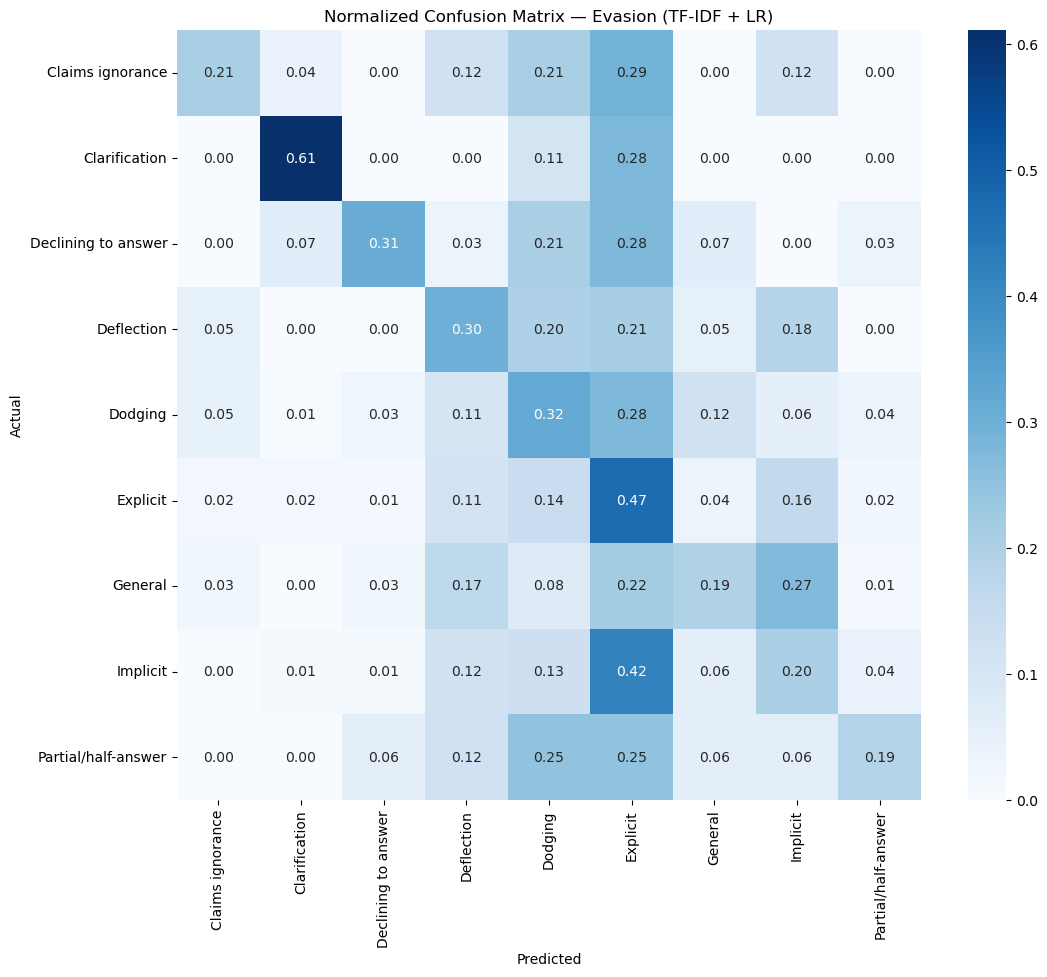

In [12]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels
true_labels = val_split["label"]

# Get label order (important for correct rows/columns)
label_names = sorted(train_split["label"].unique())

# Compute confusion matrix
cm_norm = confusion_matrix(true_labels, val_preds, labels=label_names, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix — Evasion (TF-IDF + LR)")
plt.show()

What have we done so far?
- Loaded datasets
- Built a baseline model for evasion task using Logisitic Regression
- Evaluated the model
  1. Better Performing: Clarification, Explicit, Decling to answer (These are the clear ones - not confusing)
  2. Intermediate Performing: Deflection, Dodging
  3. Worst Performing: Implicit, Claims Ignorance, Partial/Half Answer, General

  